## 1. Data Exploration

In [2]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from src.data_setup import download_dataset, load_local_data, view_dataset, sanitize_dataset, save_dataset_locally
from PIL import Image
from matplotlib import pyplot as plt

### 1.1 Download dataset

The pokemon dataset is already downloaded. Loading locally from ../data


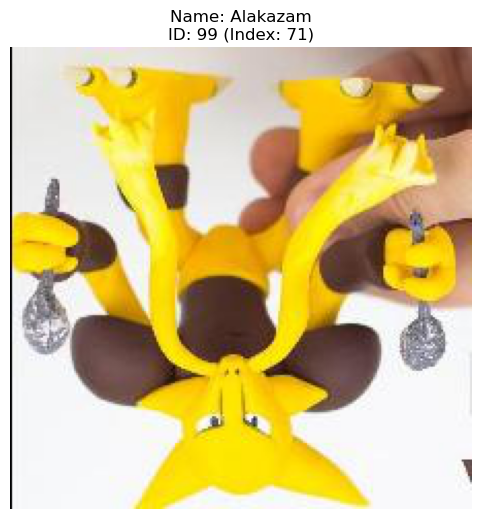

In [3]:
# Download and and load dataset
download_dataset()
dataset = load_local_data()
view_dataset(dataset, idx=71)


This dataset already contains augmented images. We will address this later by ensuring only original images end up in the test and validation datasets.

### 1.2 Check labels of train, test, split

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4939
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1460
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 802
    })
})

In [5]:
def get_label_counts(dataset, splits):
    for ds in splits:
        actual_labels = dataset[ds]['labels']

        # Find unique values
        unique_labels = np.unique(actual_labels)
        print(f"Number of {ds} labels found: {len(unique_labels)}")
        print(f"Max label ID: {max(unique_labels)}")
get_label_counts(dataset, ["train", "validation", "test"])


Number of train labels found: 137
Max label ID: 149
Number of validation labels found: 35
Max label ID: 147
Number of test labels found: 48
Max label ID: 147


We have 137 labels in our training dataset, but 35 and 48 in our validation and test datasets respectively. This means the current way in which the data is split will not allow us to accurately measure the performance of our model. 

Additionally, the labels of our data are not contiguous. The solution -> create new train, validation, and test splits and map old labels to new, contiguous labels if needed after splits are done.

In [6]:
from datasets import concatenate_datasets

# Merge three splits into one dataset
ds_full = concatenate_datasets([dataset['train'], dataset['validation'], dataset['test']])
# Remove augmented images from dataset
ds_sanitized = sanitize_dataset(ds_full)



Exporting images for deep analysis...


2026-01-07 20:49:01,218: INFO Device set to cpu ..
2026-01-07 20:49:01,220: INFO Initialized: mobilenet_v3_small for feature extraction ..
2026-01-07 20:49:01,220: INFO Start: Image encoding generation
2026-01-07 20:50:58,198: INFO End: Image encoding generation
2026-01-07 20:50:58,308: INFO Start: Calculating cosine similarities...
2026-01-07 20:50:58,507: INFO End: Calculating cosine similarities.


Found 5840 unique 'Parent' images out of 7201 total.


In [8]:
print(ds_sanitized)

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 5840
})


In [7]:
save_dataset_locally(ds_sanitized)



Saving dataset to /Users/yassinkina/Desktop/Github/portfolio/pokemon/data/pokemon_clean...


Saving the dataset (0/1 shards):   0%|          | 0/5840 [00:00<?, ? examples/s]

Save complete!


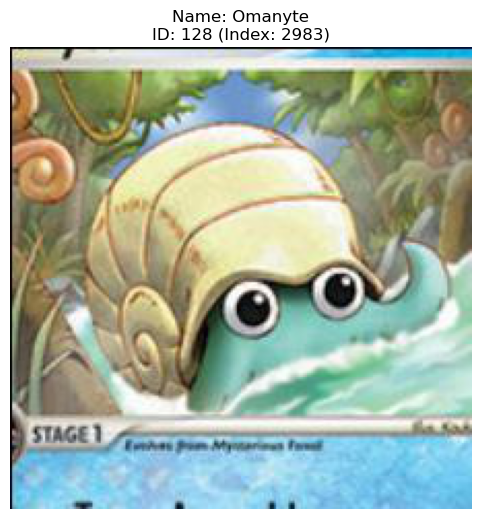

In [41]:
view_dataset(ds_splits, "train", idx=2983)

Verify that each split has the same number of labels

In [13]:
get_label_counts(final_ds, ["train", "val", "test"])


Number of train labels found: 150
Max label ID: 149
Number of val labels found: 150
Max label ID: 149
Number of test labels found: 150
Max label ID: 149


Labels are 0 indexed, as there are 150 labels with the max id label being 149. Now we need to check how imbalanced the data is.

In [14]:
from collections import Counter

counts = Counter(final_ds['train']['labels'])
print(f"Most common class count: {max(counts.values())}")
print(f"Least common class count: {min(counts.values())}")

Most common class count: 57
Least common class count: 28
